# Predicting Success of MLB Teams

Author: Eric Cao

Course Project, UC Irvine, Math 10, F23

## Introduction

Among baseball executives and fans, there is much debate about the way a MLB team's roster should be constructed. Some abide by the slogan "Defense wins championships", while others place more emphasis on offense. The goal of this project is to apply machine learning methods to a dataset containing teams' stats to determine which stats, if any, have the largest effect on a team's success.

## Cleaning the Data
First import all the necessary modules and functions.

In [ ]:
import pandas as pd
import numpy as np
import altair as alt
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestClassifier
import tensorflow as tf
from sklearn.metrics import mean_squared_error, mean_absolute_error, accuracy_score, confusion_matrix, classification_report

2023-12-14 08:52:56.790851: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-12-14 08:52:57.097621: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-12-14 08:52:57.097645: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2023-12-14 08:52:57.187274: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-12-14 08:52:58.839821: W tensorflow/stream_executor/pla

In [ ]:
df_raw = pd.read_csv('mlb_teams.csv')
df_raw

,year,league_id,division_id,rank,games_played,home_games,wins,losses,division_winner,wild_card_winner,...,hits_allowed,homeruns_allowed,walks_allowed,strikeouts_by_pitchers,errors,double_plays,fielding_percentage,team_name,ball_park,home_attendance
0,1876,NL,NaN,4,70,NaN,39,31,NaN,NaN,...,732,7,104,77,442,42,0.860,Boston Red Caps,South End Grounds I,NaN
1,1876,NL,NaN,1,66,NaN,52,14,NaN,NaN,...,608,6,29,51,282,33,0.899,Chicago White Stockings,23rd Street Grounds,NaN
2,1876,NL,NaN,8,65,NaN,9,56,NaN,NaN,...,850,9,34,60,469,45,0.841,Cincinnati Reds,Avenue Grounds,NaN
3,1876,NL,NaN,2,69,NaN,47,21,NaN,NaN,...,570,2,27,114,337,27,0.888,Hartford Dark Blues,Hartford Ball Club Grounds,NaN
4,1876,NL,NaN,5,69,NaN,30,36,NaN,NaN,...,605,3,38,125,397,44,0.875,Louisville Grays,Louisville Baseball Park,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2779,2020,NL,C,3,58,27.0,30,28,N,Y,...,376,69,204,464,33,46,0.983,St. Louis Cardinals,Busch Stadium III,0.0
2780,2020,AL,E,1,60,29.0,40,20,Y,N,...,475,70,168,552,33,52,0.985,Tampa Bay Rays,Tropicana Field,0.0
2781,2020,AL,W,5,60,30.0,22,38,N,N,...,479,81,236,489,40,40,0.981,Texas Rangers,Globe Life Field,0.0
2782,2020,AL,E,3,60,26.0,32,28,N,Y,...,517,81,250,519,38,47,0.982,Toronto Blue Jays,Sahlen Field,0.0


My dataset contains data on teams spanning back to 1876. I will remove the unimportant columns. Some stats were not yet created and collected back then, so I will also remove the rows that do not contain this data.

In [ ]:
df_count = df_raw.drop(['league_id', 'division_id', 'rank', 'home_games',  'team_name', 'ball_park', 'home_attendance'], axis=1)
df_count = df_count[~df_count['caught_stealing'].isna() & ~df_count['sacrifice_flies'].isna()]
df_count.isna().sum(axis=0)

year                        0
games_played                0
wins                        0
losses                      0
division_winner            28
wild_card_winner          640
league_winner              28
world_series_winner        28
runs_scored                 0
at_bats                     0
hits                        0
doubles                     0
triples                     0
homeruns                    0
walks                       0
strikeouts_by_batters       0
stolen_bases                0
caught_stealing             0
batters_hit_by_pitch        0
sacrifice_flies             0
opponents_runs_scored       0
earned_runs_allowed         0
earned_run_average          0
complete_games              0
shutouts                    0
saves                       0
outs_pitches                0
hits_allowed                0
homeruns_allowed            0
walks_allowed               0
strikeouts_by_pitchers      0
errors                      0
double_plays                0
fielding_p

Note: There are missing values in the columns `division_winner`, `wild_card_winner`, `league_winner`, and `world_series_winner`. I have not removed the rows corresponding to these missing values because I will not be using these columns for the first two models.

## Linear Regression Model
One way to determine a team's success is by its winning percentage. Since this dataset only contains number of wins, I will add a `win_percentage` column to it.

In [ ]:
df_count['win_percentage'] = df_count['wins'] / df_count['games_played']

Many of the stats use different scales, so I will normalize all the stats on a scale of 0 to 1 using `MinMaxScaler`. This will allow the data to be correctly analyzed via machine learning methods. I got this idea from ChatGPT.

In [ ]:
df_rate = df_count.copy()
scaler = MinMaxScaler()

cols = list(df_rate.loc[:, 'runs_scored': 'fielding_percentage'].columns)
df_rate[cols] = scaler.fit_transform(df_rate[cols])
df_rate

,year,games_played,wins,losses,division_winner,wild_card_winner,league_winner,world_series_winner,runs_scored,at_bats,...,saves,outs_pitches,hits_allowed,homeruns_allowed,walks_allowed,strikeouts_by_pitchers,errors,double_plays,fielding_percentage,win_percentage
1370,1970,162,76,86,N,NaN,N,N,0.654430,0.941673,...,0.290323,0.937052,0.791605,0.547170,0.521127,0.440339,0.675978,0.491329,0.391304,0.469136
1371,1970,162,108,54,Y,NaN,Y,Y,0.725316,0.941425,...,0.403226,0.984018,0.692931,0.373585,0.507042,0.425712,0.541899,0.664740,0.565217,0.666667
1372,1970,162,87,75,N,NaN,N,N,0.717722,0.938943,...,0.612903,0.952381,0.747423,0.437736,0.702660,0.473441,0.759777,0.566474,0.260870,0.537037
1373,1970,162,86,76,N,NaN,N,N,0.521519,0.938198,...,0.693548,0.968037,0.665685,0.430189,0.647887,0.411085,0.597765,0.786127,0.521739,0.530864
1374,1970,162,56,106,N,NaN,N,N,0.524051,0.933730,...,0.387097,0.936725,0.867452,0.467925,0.643192,0.287914,0.810056,0.890173,0.304348,0.345679
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2779,2020,58,30,28,N,Y,N,N,0.026582,0.000000,...,0.112903,0.000000,0.000000,0.109434,0.092332,0.058507,0.072626,0.075145,0.652174,0.517241
2780,2020,60,40,20,Y,N,Y,N,0.088608,0.055349,...,0.274194,0.053490,0.072901,0.113208,0.035994,0.126251,0.072626,0.109827,0.739130,0.666667
2781,2020,60,22,38,N,N,N,N,0.006329,0.045669,...,0.064516,0.042727,0.075847,0.154717,0.142410,0.077752,0.111732,0.040462,0.565217,0.366667
2782,2020,60,32,28,N,Y,N,N,0.105063,0.067262,...,0.177419,0.050554,0.103829,0.154717,0.164319,0.100847,0.100559,0.080925,0.608696,0.533333


Because the target variable `win_percentage` is quantitative, determining the relationship between the stats and `win_percentage` is a regression problem. Therefore, I need to fit a linear regression model between each stat and `win_percentage`, returning each model's coefficient, mean squared error, and mean absolute error.

In [ ]:
reg = LinearRegression()
coefs = []
mse = []
mae = []

for col in cols:
    reg.fit(df_rate[[col]], df_rate['win_percentage'])
    coefs.append(reg.coef_[0])
    mse.append(mean_squared_error(df_rate['win_percentage'], reg.predict(df_rate[[col]])))
    mae.append(mean_absolute_error(df_rate['win_percentage'], reg.predict(df_rate[[col]])))

df_rate_reg = pd.DataFrame({'Stat': cols, 'Coefficient': coefs, 'Mean Squared Error': mse, 'Mean Absolute Error': mae})
df_rate_reg

,Stat,Coefficient,Mean Squared Error,Mean Absolute Error
0,runs_scored,0.188315,0.004267,0.052642
1,at_bats,0.011933,0.005020,0.058330
2,hits,0.087089,0.004877,0.057019
3,doubles,0.076541,0.004881,0.057288
4,triples,0.017559,0.005017,0.058268
5,homeruns,0.128334,0.004606,0.055547
6,walks,0.156944,0.004541,0.054853
7,strikeouts_by_batters,-0.024567,0.005004,0.058242
8,stolen_bases,0.068245,0.004951,0.057895
9,caught_stealing,-0.024082,0.005011,0.058374


Each stat's corresponding coefficient, mean squared error, and mean absolute error are visualized below in three bar charts.

In [ ]:
alt.Chart(df_rate_reg).mark_bar().encode(
    x = 'Stat',
    y = 'Coefficient'
)

alt.Chart(...)

In [ ]:
alt.Chart(df_rate_reg).mark_bar(color = 'lightgreen').encode(
    x = 'Stat',
    y = 'Mean Squared Error'
)

alt.Chart(...)

In [ ]:
alt.Chart(df_rate_reg).mark_bar(color = 'darkgreen').encode(
    x = 'Stat',
    y = 'Mean Absolute Error'
)

alt.Chart(...)

`earned_run_average`, `earned_runs_allowed`, and `opponents_run_scored` have the largest absolute value of all coefficients, with an average coefficient of $-0.22$. The negative value of the coefficient means that higher values of each of the three stats correlates to a lower `win_percentage`, so successful teams have lower earned runs allowed. Furthermore, these three stats have the lowest mean squared error and lowest mean absolute error of all stats, meaning that these stats are the best predictors of `win_percentage`.

## Random Forest Classifier
A binary way to determine a team's success is to determine if it is a winning team, which means that its win percentage is over 50%. This will be represented by the `is_win` column.

In [ ]:
df_rate['is_win'] = (df_rate['win_percentage'] >= 0.5)
df_rate

,year,games_played,wins,losses,division_winner,wild_card_winner,league_winner,world_series_winner,runs_scored,at_bats,...,outs_pitches,hits_allowed,homeruns_allowed,walks_allowed,strikeouts_by_pitchers,errors,double_plays,fielding_percentage,win_percentage,is_win
1370,1970,162,76,86,N,NaN,N,N,0.654430,0.941673,...,0.937052,0.791605,0.547170,0.521127,0.440339,0.675978,0.491329,0.391304,0.469136,False
1371,1970,162,108,54,Y,NaN,Y,Y,0.725316,0.941425,...,0.984018,0.692931,0.373585,0.507042,0.425712,0.541899,0.664740,0.565217,0.666667,True
1372,1970,162,87,75,N,NaN,N,N,0.717722,0.938943,...,0.952381,0.747423,0.437736,0.702660,0.473441,0.759777,0.566474,0.260870,0.537037,True
1373,1970,162,86,76,N,NaN,N,N,0.521519,0.938198,...,0.968037,0.665685,0.430189,0.647887,0.411085,0.597765,0.786127,0.521739,0.530864,True
1374,1970,162,56,106,N,NaN,N,N,0.524051,0.933730,...,0.936725,0.867452,0.467925,0.643192,0.287914,0.810056,0.890173,0.304348,0.345679,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2779,2020,58,30,28,N,Y,N,N,0.026582,0.000000,...,0.000000,0.000000,0.109434,0.092332,0.058507,0.072626,0.075145,0.652174,0.517241,True
2780,2020,60,40,20,Y,N,Y,N,0.088608,0.055349,...,0.053490,0.072901,0.113208,0.035994,0.126251,0.072626,0.109827,0.739130,0.666667,True
2781,2020,60,22,38,N,N,N,N,0.006329,0.045669,...,0.042727,0.075847,0.154717,0.142410,0.077752,0.111732,0.040462,0.565217,0.366667,False
2782,2020,60,32,28,N,Y,N,N,0.105063,0.067262,...,0.050554,0.103829,0.154717,0.164319,0.100847,0.100559,0.080925,0.608696,0.533333,True


Because the target variable `is_win` is categorical, the model will use each row's stats to determine its class in `is_win`, which is a classification problem. Therefore, I will use a random forest to model the relationship between stats and `is_win`. One of the main advantages of a random forest is its robustness, which counters overfitting. I also separated the data into training and testing data, which allow us to see if the random forest has overfit our data by testing the model on the testing data.

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(df_rate[cols], df_rate['is_win'], test_size=0.2)

rfc = RandomForestClassifier(n_estimators=100, max_leaf_nodes=len(cols))
rfc.fit(X_train, y_train)
rfc_train_pred = rfc.predict(X_train)
rfc_test_pred = rfc.predict(X_test)

I will determine the accuracy of the random forest model on both the training and testing data.

In [ ]:
accuracy_score(y_train, rfc_train_pred)

0.9540229885057471

In [ ]:
accuracy_score(y_test, rfc_test_pred)

0.9293286219081273

The accuracy scores of the random forest classifier on the training data and testing data are both over $0.90$, which does not suggest that the random forest has overfit the data. Next, I will visualize this with a confusion matrix, the code for which I obtained from: https://medium.com/analytics-vidhya/evaluating-a-random-forest-model-9d165595ad56

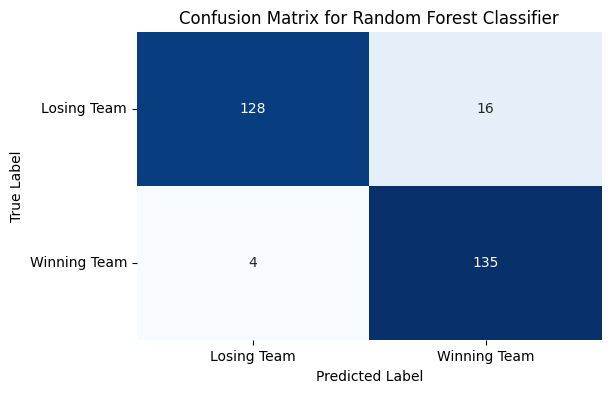

In [ ]:
matrix = confusion_matrix(y_test, rfc_test_pred)
plt.figure(figsize=(6, 4))
sns.heatmap(matrix, annot=True, cmap='Blues', fmt='d', cbar=False)

class_names = ['Losing Team', 'Winning Team']
tick_marks = np.arange(len(class_names)) + 0.5
plt.xticks(tick_marks, class_names, rotation=0)
plt.yticks(tick_marks, class_names, rotation=0)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix for Random Forest Classifier')
plt.show()

A classification report will sum up the confusion matrix with three metrics: precision, recall, and f1 score.
According to https://medium.com/analytics-vidhya/evaluating-a-random-forest-model-9d165595ad56:
1) Precision is the number of correctly-identified members of a class divided by all the times the model predicted that class. 
2) Recall is the number of members of a class that the classifier identified correctly divided by the total number of members in that class. 
3) F1 score combines precision and recall into one metric. If precision and recall are both high, F1 will be high, too. If they are both low, F1 will be low. If one is high and the other low, F1 will be low.

In [ ]:
print(classification_report(y_test, rfc_test_pred))

              precision    recall  f1-score   support

       False       0.97      0.89      0.93       144
        True       0.89      0.97      0.93       139

    accuracy                           0.93       283
   macro avg       0.93      0.93      0.93       283
weighted avg       0.93      0.93      0.93       283



Because the precision, recall, and f1 scores for both classes are high ($\geq0.89$), we can conclude that the random forest model is accurate at predicting whether a team has a winning record based on their stats. We can now analyze which stats were most important in determining a team's success.

In [ ]:
pd.Series(rfc.feature_importances_, index=rfc.feature_names_in_).sort_values(ascending=False)

runs_scored               0.192366
earned_run_average        0.134273
opponents_runs_scored     0.113034
earned_runs_allowed       0.091288
saves                     0.067500
hits                      0.064919
walks_allowed             0.048037
homeruns                  0.044631
hits_allowed              0.035169
walks                     0.033901
shutouts                  0.024170
outs_pitches              0.021774
doubles                   0.014424
at_bats                   0.014272
homeruns_allowed          0.012837
errors                    0.012371
sacrifice_flies           0.012179
strikeouts_by_batters     0.008981
fielding_percentage       0.008807
triples                   0.007699
strikeouts_by_pitchers    0.007344
complete_games            0.006878
caught_stealing           0.006677
stolen_bases              0.006267
batters_hit_by_pitch      0.005247
double_plays              0.004955
dtype: float64

`runs_scored`, `opponents_runs_scored`, and `earned_run_average` had the highest feature importances, which means that they were the most significant stats towards a team's success. This agrees with the previous results found in the linear regression model, which found that `earned_run_average` had the greatest negative effect on winning percentage and `runs_scored` had one of the greatest positive effects on winning percentage.

## Neural Network
Another criteria to judge a team's success is how far it goes in the playoffs. Now I will drop the rows with missing values in `wild_card_winner`.

In [ ]:
df_playoffs = df_rate[~df_rate['wild_card_winner'].isna()]
df_playoffs.isna().sum(axis=0)

year                      0
games_played              0
wins                      0
losses                    0
division_winner           0
wild_card_winner          0
league_winner             0
world_series_winner       0
runs_scored               0
at_bats                   0
hits                      0
doubles                   0
triples                   0
homeruns                  0
walks                     0
strikeouts_by_batters     0
stolen_bases              0
caught_stealing           0
batters_hit_by_pitch      0
sacrifice_flies           0
opponents_runs_scored     0
earned_runs_allowed       0
earned_run_average        0
complete_games            0
shutouts                  0
saves                     0
outs_pitches              0
hits_allowed              0
homeruns_allowed          0
walks_allowed             0
strikeouts_by_pitchers    0
errors                    0
double_plays              0
fielding_percentage       0
win_percentage            0
is_win              

I will create a new column in `df_playoffs` called `playoffs` that correlates to how far each team made in the playoffs. $0$ correlates to no playoff series wins, $1$ correlates to winning the wild card, $2$ correlates to winning the league championship series, and $3$ correlates to winning the world series. I created `playoffs` using code from: https://stackoverflow.com/questions/26886653/create-new-column-based-on-values-from-other-columns-apply-a-function-of-multi

In [ ]:
conditions = [df_playoffs['world_series_winner'] == 'Y', df_playoffs['league_winner'] == 'Y', df_playoffs['wild_card_winner'] == 'Y']
outputs = [3, 2, 1]
df_playoffs['playoffs'] = np.select(conditions, outputs)
df_playoffs

/tmp/ipykernel_37/169299682.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_playoffs['playoffs'] = np.select(conditions, outputs)


,year,games_played,wins,losses,division_winner,wild_card_winner,league_winner,world_series_winner,runs_scored,at_bats,...,hits_allowed,homeruns_allowed,walks_allowed,strikeouts_by_pitchers,errors,double_plays,fielding_percentage,win_percentage,is_win,playoffs
2010,1995,144,90,54,Y,N,Y,Y,0.539241,0.759990,...,0.594993,0.252830,0.455399,0.538106,0.446927,0.462428,0.608696,0.625000,True,3
2011,1995,144,71,73,N,N,N,N,0.613924,0.765699,...,0.581001,0.411321,0.591549,0.417244,0.290503,0.624277,0.782609,0.493056,False,0
2012,1995,144,86,58,Y,N,N,N,0.724051,0.805411,...,0.708395,0.328302,0.517997,0.384911,0.558659,0.682081,0.434783,0.597222,True,0
2013,1995,145,78,67,N,N,N,N,0.736709,0.810871,...,0.687776,0.464151,0.533646,0.394919,0.418994,0.502890,0.608696,0.537931,True,0
2014,1995,145,68,76,N,N,N,N,0.678481,0.821047,...,0.734904,0.467925,0.738654,0.387991,0.491620,0.566474,0.521739,0.468966,False,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2779,2020,58,30,28,N,Y,N,N,0.026582,0.000000,...,0.000000,0.109434,0.092332,0.058507,0.072626,0.075145,0.652174,0.517241,True,1
2780,2020,60,40,20,Y,N,Y,N,0.088608,0.055349,...,0.072901,0.113208,0.035994,0.126251,0.072626,0.109827,0.739130,0.666667,True,2
2781,2020,60,22,38,N,N,N,N,0.006329,0.045669,...,0.075847,0.154717,0.142410,0.077752,0.111732,0.040462,0.565217,0.366667,False,0
2782,2020,60,32,28,N,Y,N,N,0.105063,0.067262,...,0.103829,0.154717,0.164319,0.100847,0.100559,0.080925,0.608696,0.533333,True,1


Because the target variable `is_win` is categorical, the model will use each row's stats to determine its class in `playoffs`, which is a classification problem. Therefore, I will try to use a neural network to model the relationship between stats and `playoffs`, using the code from https://www.tensorflow.org/tutorials/keras/classification. I also separated the data into training and testing data, which allow us to see if the neural network has overfit our data by testing the model on the testing data.

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(df_playoffs[cols], df_playoffs['playoffs'], test_size=0.2)

model = tf.keras.Sequential([
    tf.keras.layers.Dense(30, activation='relu'),
    tf.keras.layers.Dense(4)
])
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])
model.fit(X_train, y_train, epochs=10);

Epoch 1/10
20/20 [==============================] - 1s 5ms/step - loss: 0.9253 - accuracy: 0.8336
Epoch 2/10
20/20 [==============================] - 0s 5ms/step - loss: 0.6009 - accuracy: 0.8627
Epoch 3/10
20/20 [==============================] - 0s 5ms/step - loss: 0.5611 - accuracy: 0.8627
Epoch 4/10
20/20 [==============================] - 0s 5ms/step - loss: 0.5538 - accuracy: 0.8627
Epoch 5/10
20/20 [==============================] - 0s 1ms/step - loss: 0.5485 - accuracy: 0.8627
Epoch 6/10
20/20 [==============================] - 0s 2ms/step - loss: 0.5459 - accuracy: 0.8627
Epoch 7/10
20/20 [==============================] - 0s 2ms/step - loss: 0.5434 - accuracy: 0.8627
Epoch 8/10
20/20 [==============================] - 0s 5ms/step - loss: 0.5411 - accuracy: 0.8627
Epoch 9/10
20/20 [==============================] - 0s 4ms/step - loss: 0.5399 - accuracy: 0.8627
Epoch 10/10
20/20 [==============================] - 0s 5ms/step - loss: 0.5374 - accuracy: 0.8627


The model's accuracy on the training data is $0.8627$ (above), while the model's accuracy on the testing data is $0.8065$ (below). 

In [ ]:
test_loss, test_acc = model.evaluate(X_test,  y_test, verbose=2)
print('Test accuracy:', test_acc)

5/5 - 0s - loss: 0.6691 - accuracy: 0.8065 - 86ms/epoch - 17ms/step
Test accuracy: 0.8064516186714172


Now let's look at the values predicted by the model.

In [ ]:
probability_model = tf.keras.Sequential([model, 
                                         tf.keras.layers.Softmax()])
predictions = probability_model.predict(X_test)
lst = [np.argmax(row) for row in predictions]
np.unique(lst, return_counts=True)

5/5 [==============================] - 0s 2ms/step


(array([0]), array([155]))

This indicates that the model has predicted all teams in the testing data to belong to the $0$ class of `playoffs`. Evidently, the neuron network was not able to distinguish a significant difference in the stats between teams that had playoff success and teams that did not. Therefore, none of the stats are statistically significant in determining a team's playoff success.

## Summary

Using linear regression and a random forest, I determined that a MLB team's success during the regular season can be predicted by some stats. In particular, runs scored and saves positively correlate to wins, while runs allowed and walks allowed negatively correlate to wins. However, there appears to be no correlation between any of the stats and a team's playoff success, as shown by a neural network.

## References

Your code above should include references.  Here is some additional space for references.

* What is the source of your dataset(s)?
https://www.retrosheet.org

* List any other references that you found helpful.